# Detección de Espacios de Estacionamiento en la Ciudad de Granada.
## Segmentación de Imágenes con técnicas de Deep Learning.
### Notebook 3.1: Modelo de Segmentación de Imágenes con DeepLabV3+.

### Autores:
- **Luis Crespo Orti**
- **Isabel María Moreno Cuadrado**
- **Pablo Olivares Martínez**
- **Ximo Sanz Tornero**


## 1. Importación de librerías y funciones.

In [1]:
%pip install torch torchvision fastai segmentation-models-pytorch opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import csv

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [4]:
!nvidia-smi

Sun Jan  7 21:19:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              N/A / ERR! |      1MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

NVIDIA GeForce GTX 1050
True


In [6]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off()
           for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i ==
                0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [7]:
# Function to save the metrics to a csv file
def save_metrics_to_csv(learner, file_path='deeplab_metrics.csv', **kwargs):
    recorder = learner.recorder
    metrics = np.stack(recorder.values)
    names = recorder.metric_names[1:-1]

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Escribir las cabeceras (nombres de las métricas)
        writer.writerow(['epoch'] + names)

        # Escribir las métricas por época
        for epoch, metric_values in enumerate(metrics):
            writer.writerow([epoch + 1] + list(metric_values))

    print(f"Metrics saved to {file_path}")

## 2. Carga y preparación de los datos.

In [8]:
path_to_dataset = Path('/media/HDD/Documentos/DGIIM5/UDD5_3C_AUGMENTED/train')

In [9]:
def get_y_fn(x):
    """
    Dada la ruta de una imagen, devuelve la ruta de su máscara correspondiente.
    """
    return Path(str(x).replace('src', 'gt').replace('.JPG', '.png'))


def get_items(path):
    """
    Obtiene una lista de todas las imágenes en el directorio 'src'.
    """
    return get_image_files(path/'src')

In [10]:
# Definición de la función para normalizar la máscara
def normalize_mask(mask, mapping):
    if mask.ndim != 3 or mask.shape[-1] != 3:
        raise ValueError(
            "La máscara debe ser una imagen RGB con 3 canales de color.")
    h, w, _ = mask.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, c in mapping.items():
        mask_class[(mask == color).all(axis=-1)] = c
    return mask_class

# Definición de la función para denormalizar la máscara
def denormalize_mask(mask_class, mapeo):
    inverse_map = {v: k for k, v in mapeo.items()}
    h, w = mask_class.shape
    mask_color = np.zeros((h, w, 3), dtype=np.uint8)
    for c in np.unique(mask_class):
        color = inverse_map[c]
        mask_color[mask_class == c] = color
    return mask_color


# Mapeo de color a clase para la normalización de máscaras
mapping_class_color = {
    (107, 142, 35): 0,  # Clase 0 - Background
    (102, 102, 156): 0,  # Clase 0
    (128, 64, 128): 1,  # Clase 1 - Road
    (0, 0, 142): 2,  # Clase 2 - Car
    (0, 0, 0): 0,     # Clase 0
}

# Función para obtener la máscara normalizada
def get_mask(item):
    msk_path = get_y_fn(item)
    msk = np.array(PILImage.create(msk_path))
    return PILMask.create(normalize_mask(msk, mapping_class_color))

In [11]:
# Función para añadir sombras a las imágenes
def add_shadow(image, num_shadows, min_opacity, max_opacity):
    height, width = image.shape[:2]
    shadow_image = image.copy()

    for _ in range(num_shadows):
        # Randomly generate the shadow polygon
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        x3, y3 = random.randint(0, width), random.randint(0, height)
        x4, y4 = random.randint(0, width), random.randint(0, height)

        # Create a black polygon to simulate the shadow
        poly = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
        cv2.fillPoly(shadow_image, [poly], (0, 0, 0))

        # Blending the shadow with the image
        alpha = random.uniform(min_opacity, max_opacity)
        mask = shadow_image.astype(bool)
        shadow_image = cv2.addWeighted(shadow_image, alpha, image, 1 - alpha, 0, image)
        image[mask] = shadow_image[mask]

    return image

class ShadowTransform(Transform):
    """
    Custom Transform for adding shadows.
    """
    def __init__(self, num_shadows=3, min_opacity=0.5, max_opacity=0.75):
        self.num_shadows = num_shadows
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity

    def encodes(self, x: PILImage):
        return add_shadow(x, self.num_shadows, self.min_opacity, self.max_opacity)

In [12]:
# Transformaciones por defecto
aug_transforms = aug_transforms(mult=2, do_flip=True, flip_vert=True, 
                                max_rotate=90., min_zoom=0.8, max_zoom=3.0, 
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75, 
                                p_lighting=0.75, xtra_tfms=None, size=None, 
                                mode='bilinear', pad_mode='reflection', 
                                align_corners=True, batch=False, min_scale=1)

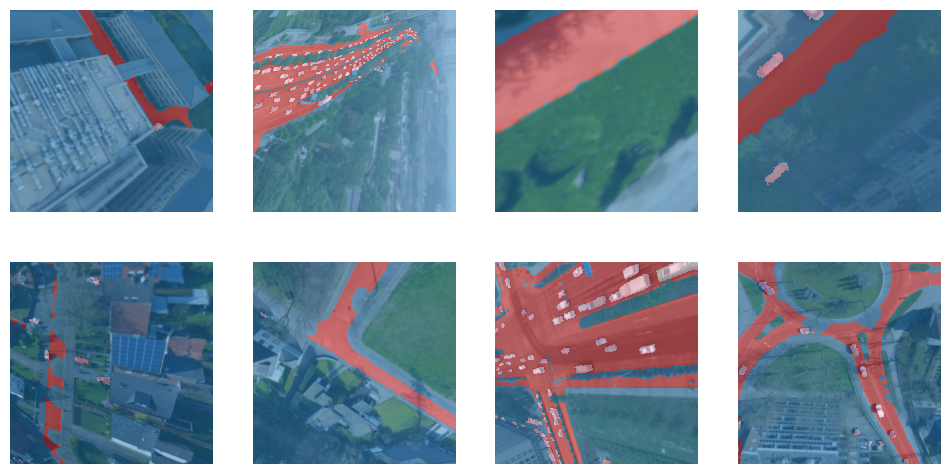

In [13]:
# Definir el número de clases en tu conjunto de datos
num_classes = 3

# Definir el formato de los bloques de datos
data = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(num_classes))),
    get_items=get_items,
    get_y=get_mask,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=Resize((304, 456)),
    batch_tfms=[*aug_transforms, ShadowTransform(
        num_shadows=3, min_opacity=0.5, max_opacity=0.75), Normalize.from_stats(*imagenet_stats)]
)

# Crea DataLoaders y muestra un lote de entrenamiento
dls = data.dataloaders(path_to_dataset, bs=32)
dls.train.show_batch(max_n=8)

In [14]:
# Vemos la forma de un lote
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([32, 3, 304, 304]), torch.Size([32, 304, 304]))

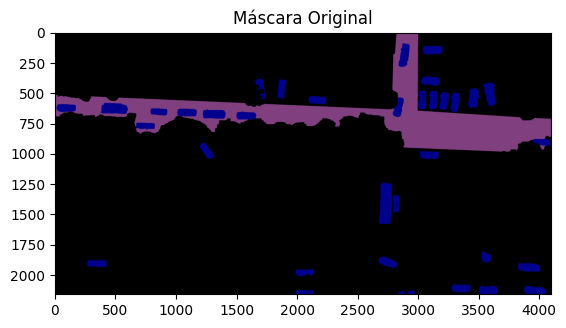

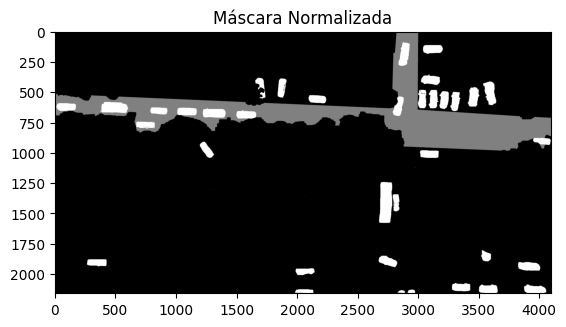

In [15]:
path_to_image = '/media/HDD/Documentos/DGIIM5/UDD5_3C_AUGMENTED/train/src/000001.JPG'  # Cambia esto por una ruta real
mask_path = get_y_fn(path_to_image)

# Cargar la máscara original
original_mask = PILImage.create(mask_path)
plt.imshow(original_mask)
plt.title("Máscara Original")
plt.show()

# Aplicar normalización
normalized_mask = normalize_mask(np.array(original_mask), mapping_class_color)
plt.imshow(normalized_mask, cmap='gray')
plt.title("Máscara Normalizada")
plt.show()

## 3. Implementación del modelo.

In [16]:
def FWIoU(preds, targs, num_classes=3):
    # Calcula las matrices de confusión para cada clase
    confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.float32)
    for t, p in zip(targs.view(-1), preds.argmax(dim=1).view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # Calcula la IoU para cada clase
    I = torch.diag(confusion_matrix)
    U = confusion_matrix.sum(dim=1) + confusion_matrix.sum(dim=0) - I
    IoU = I / U

    # Calcula la frecuencia de cada clase
    freq = confusion_matrix.sum(dim=1) / confusion_matrix.sum()

    # Calcula el FWIoU
    FWIoU = (freq[freq > 0] * IoU[freq > 0]).sum()

    return FWIoU

In [17]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = num_classes
ACTIVATION = None

# Importamos el modelo DeepLabV3Plus
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

In [18]:
# Crear un objeto de tipo Learner
learner = Learner(dls, model,loss_func=FocalLoss(), metrics=[foreground_acc, DiceMulti(), JaccardCoeffMulti()])

## 4. Entrenamiento del modelo.

In [19]:
# Entrenar el modelo
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,foreground_acc,dice_multi,jaccard_coeff_multi,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 92.00 MiB. GPU 0 has a total capacty of 3.95 GiB of which 4.94 MiB is free. Including non-PyTorch memory, this process has 3.94 GiB memory in use. Of the allocated memory 3.74 GiB is allocated by PyTorch, and 100.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
save_metrics_to_csv(learner, file_path='pspnet_metrics.csv')

In [ ]:
learner.show_results()

## 5. Evaluación del modelo.

In [ ]:
# Preparar el conjunto de datos de prueba
path_test = Path('/media/HDD/Documentos/DGIIM5/UDD5_3C_AUGMENTED/val')
test_items = get_items(path_test)
test_dl = learner.dls.test_dl(test_items)

# Realizar predicciones
preds, _ = learner.get_preds(dl=test_dl)

In [ ]:
# Visualizar los resultados
for i, (img, pred) in enumerate(zip(test_dl.items, preds)):
    original_image = PILImage.create(img)
    true_mask_path = get_y_fn(img)
    true_mask = PILImage.create(true_mask_path)
    predicted_mask = denormalize_mask(pred.argmax(dim=0).numpy(), mapping_class_color)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask")

    plt.show()

OSError: [Errno 107] Transport endpoint is not connected

In [ ]:
# Exportar los pesos del modelo
learner.export(fname='deeplab.pkl')